#Capstone : Phase 1

---

##Mount Google Drive

In [2]:
 from google.colab import drive
 
 drive.mount('/content/gdrive')

Mounted at /content/gdrive


---

##Import Libraries

In [ ]:
import tensorflow as tf
import cv2
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import activations

from keract import get_activations, display_heatmaps, display_activations

In [ ]:
# pip install keract

---

###Function to Crop Face

In [ ]:
def detectFaceOpenCVHaar(framepath, inHeight=300, inWidth=0):
    frame = cv2.imread(framepath)
    frameOpenCVHaar = frame.copy()
    frameHeight = frameOpenCVHaar.shape[0]
    frameWidth = frameOpenCVHaar.shape[1]
    if not inWidth:
        inWidth = int((frameWidth / frameHeight) * inHeight)

    scaleHeight = frameHeight / inHeight
    scaleWidth = frameWidth / inWidth

    frameOpenCVHaarSmall = cv2.resize(frameOpenCVHaar, (inWidth, inHeight))
    frameGray = cv2.cvtColor(frameOpenCVHaarSmall, cv2.COLOR_BGR2GRAY)

    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = faceCascade.detectMultiScale(frameGray)
    bboxes = []
    for (x, y, w, h) in faces:
        x1 = x
        y1 = y
        x2 = x + w
        y2 = y + h
        cvRect = [int(x1 * scaleWidth), int(y1 * scaleHeight),
                  int(x2 * scaleWidth), int(y2 * scaleHeight)]
        bboxes.append(cvRect)
        cv2.rectangle(frameOpenCVHaar, (cvRect[0], cvRect[1]), (cvRect[2], cvRect[3]), (0, 255, 0),
                      int(round(frameHeight / 150)), 4)
      
    cropped_image = frameOpenCVHaar[cvRect[1]:cvRect[3], cvRect[0]:cvRect[2]]
    cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
    return cropped_image

In [ ]:
def img_show(path):
  cropped = detectFaceOpenCVHaar(path)  
  plt.imshow(cropped, cmap="gray", vmin=0, vmax=255)

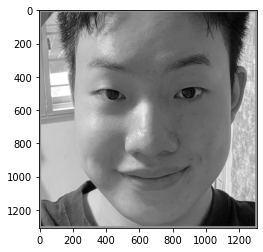

In [ ]:
img_show('/content/gdrive/MyDrive/Colab Notebooks/Capstone/train/happy/IMG_9468.JPG')

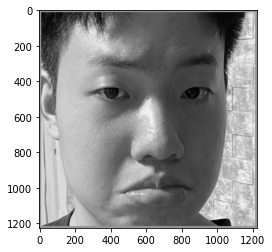

In [ ]:
img_show('/content/gdrive/MyDrive/Colab Notebooks/Capstone/train/sad/IMG_9847.JPG')

We can see that our cropping function is doing well.

---

##Image Pre-processing

###Create Train Data

In [ ]:
def create_image_data(data,img_size, datadirectory, classes):
    for category in classes:
        path = os.path.join(datadirectory, category)
        class_num = classes.index(category)
        for img in os.listdir(path):
            try:
              #function to crop face
                img_array = detectFaceOpenCVHaar(os.path.join(path, img))
                new_array = cv2.resize(img_array, (img_size, img_size))
                data.append([new_array,class_num])
            except Exception as e:
                pass

In [ ]:
# read all the images and convert them to array
training_data = [] 

# path
datadirectory_train = '/content/gdrive/MyDrive/Colab Notebooks/Capstone/phase 1/train' 

# classes
classes = ['angry','happy','neutral','sad']

# using pre-defined function 
create_image_data(training_data, 224, datadirectory_train, classes)

###Train-Validate Split

In [ ]:
# shuffle training data 
random.shuffle(training_data)

In [ ]:
X = []
y = []

for features, label in training_data:
    X.append(features)
    y.append(label)

In [ ]:
# X forms the training images, and y forms the training labels
X = np.array(X)
y = to_categorical(y)

In [ ]:
# train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Each image's dimension is 224 x 224
img_rows, img_cols = 224, 224
input_shape = (img_rows, img_cols, 1)

# Prepare the training images
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_train = X_train.astype('float32')
X_train /= 255

# Prepare the validation images
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)
X_val = X_val.astype('float32')
X_val /= 255

###Create Test Data

In [ ]:
# read all the images and convert them to array
testing_data = [] 

# path
datadirectory_test = '/content/gdrive/MyDrive/Colab Notebooks/Capstone/phase 1/test' 

# using pre-defined function 
create_image_data(testing_data, 224, datadirectory_test, classes)

In [ ]:
# shuffle training data 
random.shuffle(testing_data)

In [ ]:
X_test = []
y_test = []

for features, label in testing_data:
    X_test.append(features)
    y_test.append(label)

In [ ]:
# X forms the testing images, and y forms the testing labels
X_test = np.array(X_test)
y_test = to_categorical(y_test)

In [ ]:
# Prepare the training images
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_test = X_test.astype('float32')
X_test /= 255

---

##Modeling

###1 Layer

In [ ]:
cnn1 = Sequential()
cnn1.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
cnn1.add(MaxPooling2D(pool_size=(2, 2)))
cnn1.add(Dropout(0.2))

cnn1.add(Flatten())

cnn1.add(Dense(128, activation='relu'))
cnn1.add(Dense(4, activation='softmax'))

cnn1.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
history1 = cnn1.fit(X_train, y_train,
          batch_size=256,
          epochs=10,
          verbose=1,
          validation_data=(X_val, y_val))

Epoch 1/10
3/3 [==============================] - 11s 182ms/step - loss: 34.3954 - accuracy: 0.2805 - val_loss: 41.3519 - val_accuracy: 0.1591
Epoch 2/10
3/3 [==============================] - 0s 46ms/step - loss: 32.5972 - accuracy: 0.2500 - val_loss: 14.3276 - val_accuracy: 0.2576
Epoch 3/10
3/3 [==============================] - 0s 50ms/step - loss: 9.7938 - accuracy: 0.1889 - val_loss: 5.6024 - val_accuracy: 0.3788
Epoch 4/10
3/3 [==============================] - 0s 45ms/step - loss: 5.7927 - accuracy: 0.2691 - val_loss: 8.5056 - val_accuracy: 0.1591
Epoch 5/10
3/3 [==============================] - 0s 45ms/step - loss: 6.5502 - accuracy: 0.3359 - val_loss: 7.0043 - val_accuracy: 0.4848
Epoch 6/10
3/3 [==============================] - 0s 45ms/step - loss: 5.6291 - accuracy: 0.3531 - val_loss: 5.3473 - val_accuracy: 0.2803
Epoch 7/10
3/3 [==============================] - 0s 45ms/step - loss: 3.8800 - accuracy: 0.3664 - val_loss: 2.5975 - val_accuracy: 0.3864
Epoch 8/10
3/3 [=====

In [ ]:
score1 = cnn1.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score1[0])
print('Test accuracy:', score1[1])

Test loss: 1.7535181045532227
Test accuracy: 0.37288135290145874


###Image Augmentation

In [ ]:
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                               height_shift_range=0.08, zoom_range=0.08)
batches = gen.flow(X_train, y_train, batch_size=256)
val_batches = gen.flow(X_val, y_val, batch_size=256)

In [ ]:
history1 = cnn1.fit_generator(batches, steps_per_epoch=48000//256, epochs=10,
                    validation_data=val_batches, validation_steps=12000//256, use_multiprocessing=True)

<ipython-input-23-fdf3b30b81de>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1 = cnn1.fit_generator(batches, steps_per_epoch=48000//256, epochs=10,


Epoch 1/10
187/187 [==============================] - 196s 1s/step - loss: 1.0746 - accuracy: 0.5421 - val_loss: 0.9156 - val_accuracy: 0.6242
Epoch 2/10
187/187 [==============================] - 195s 1s/step - loss: 0.7515 - accuracy: 0.7105 - val_loss: 0.7134 - val_accuracy: 0.7050
Epoch 3/10
187/187 [==============================] - 196s 1s/step - loss: 0.5923 - accuracy: 0.7823 - val_loss: 0.9821 - val_accuracy: 0.5883
Epoch 4/10
187/187 [==============================] - 197s 1s/step - loss: 0.5032 - accuracy: 0.8193 - val_loss: 0.5198 - val_accuracy: 0.7987
Epoch 5/10
187/187 [==============================] - 195s 1s/step - loss: 0.4213 - accuracy: 0.8517 - val_loss: 0.5373 - val_accuracy: 0.8053
Epoch 6/10
187/187 [==============================] - 190s 1s/step - loss: 0.3779 - accuracy: 0.8659 - val_loss: 0.7111 - val_accuracy: 0.7329
Epoch 7/10
187/187 [==============================] - 194s 1s/step - loss: 0.3523 - accuracy: 0.8746 - val_loss: 0.4414 - val_accuracy: 0.8287

In [ ]:
score1 = cnn1.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score1[0])
print('Test accuracy:', score1[1])

Test loss: 1.5693453550338745
Test accuracy: 0.6101694703102112


###3 Layers

In [ ]:
cnn3 = Sequential()
cnn3.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
cnn3.add(MaxPooling2D((2, 2)))
cnn3.add(Dropout(0.25))

cnn3.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn3.add(MaxPooling2D(pool_size=(2, 2)))
cnn3.add(Dropout(0.25))

cnn3.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn3.add(Dropout(0.4))

cnn3.add(Flatten())

cnn3.add(Dense(128, activation='relu'))
cnn3.add(Dropout(0.3))
cnn3.add(Dense(4, activation='softmax'))

cnn3.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
history3 = cnn3.fit(X_train, y_train,
          batch_size=256,
          epochs=10,
          verbose=1,
          validation_data=(X_val, y_val))

Epoch 1/10
3/3 [==============================] - 2s 241ms/step - loss: 15.1397 - accuracy: 0.2844 - val_loss: 3.2349 - val_accuracy: 0.1591
Epoch 2/10
3/3 [==============================] - 0s 66ms/step - loss: 3.4989 - accuracy: 0.2615 - val_loss: 1.4297 - val_accuracy: 0.2045
Epoch 3/10
3/3 [==============================] - 0s 71ms/step - loss: 1.4120 - accuracy: 0.2233 - val_loss: 1.3861 - val_accuracy: 0.2576
Epoch 4/10
3/3 [==============================] - 0s 65ms/step - loss: 1.3867 - accuracy: 0.2500 - val_loss: 1.3836 - val_accuracy: 0.3788
Epoch 5/10
3/3 [==============================] - 0s 66ms/step - loss: 1.3807 - accuracy: 0.3015 - val_loss: 1.3749 - val_accuracy: 0.3788
Epoch 6/10
3/3 [==============================] - 0s 66ms/step - loss: 1.3974 - accuracy: 0.3244 - val_loss: 1.3883 - val_accuracy: 0.3788
Epoch 7/10
3/3 [==============================] - 0s 65ms/step - loss: 1.3760 - accuracy: 0.3359 - val_loss: 1.3813 - val_accuracy: 0.3788
Epoch 8/10
3/3 [=========

In [ ]:
score3 = cnn3.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score1[0])
print('Test accuracy:', score1[1])

Test loss: 1.5693453550338745
Test accuracy: 0.6101694703102112


###Image Augmentation

In [ ]:
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                               height_shift_range=0.08, zoom_range=0.08)
batches = gen.flow(X_train, y_train, batch_size=256)
val_batches = gen.flow(X_val, y_val, batch_size=256)

In [ ]:
history3 = cnn3.fit_generator(batches, steps_per_epoch=48000//256, epochs=10,
                    validation_data=val_batches, validation_steps=12000//256, use_multiprocessing=True)

<ipython-input-29-69af42ec2e7e>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history3 = cnn3.fit_generator(batches, steps_per_epoch=48000//256, epochs=10,


Epoch 1/10
187/187 [==============================] - 196s 1s/step - loss: 1.3757 - accuracy: 0.3243 - val_loss: 1.3738 - val_accuracy: 0.3788
Epoch 2/10
187/187 [==============================] - 194s 1s/step - loss: 1.3507 - accuracy: 0.3355 - val_loss: 1.2914 - val_accuracy: 0.4216
Epoch 3/10
187/187 [==============================] - 194s 1s/step - loss: 1.0598 - accuracy: 0.5405 - val_loss: 0.8643 - val_accuracy: 0.6428
Epoch 4/10
187/187 [==============================] - 194s 1s/step - loss: 0.7030 - accuracy: 0.7140 - val_loss: 0.7296 - val_accuracy: 0.7227
Epoch 5/10
187/187 [==============================] - 194s 1s/step - loss: 0.5035 - accuracy: 0.8009 - val_loss: 0.6074 - val_accuracy: 0.7768
Epoch 6/10
187/187 [==============================] - 194s 1s/step - loss: 0.4072 - accuracy: 0.8429 - val_loss: 0.4558 - val_accuracy: 0.8259
Epoch 7/10
187/187 [==============================] - 195s 1s/step - loss: 0.3077 - accuracy: 0.8832 - val_loss: 0.4074 - val_accuracy: 0.8505

In [ ]:
score3 = cnn3.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score1[0])
print('Test accuracy:', score1[1])

Test loss: 1.5693453550338745
Test accuracy: 0.6101694703102112


###Saving Model

In [ ]:
cnn1.save('cnn1_phase1')
cnn3.save('cnn3_phase1')

###Model Evaluation

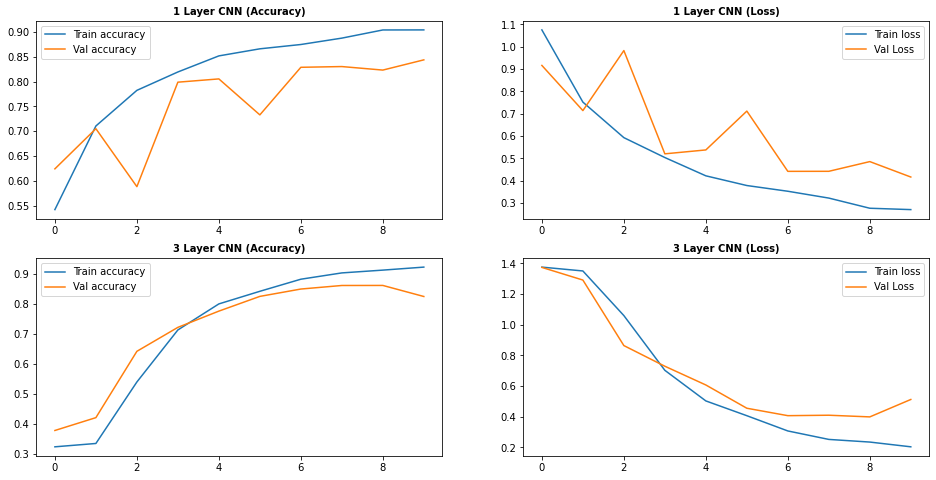

In [ ]:
plt.figure(figsize=(16,8))

plt.subplot(2,2,1)
plt.plot(history1.history['accuracy'], label='Train accuracy')
plt.plot(history1.history['val_accuracy'], label='Val accuracy')
plt.legend()
plt.title('1 Layer CNN (Accuracy)', fontweight='bold', fontsize=10)

plt.subplot(2,2,2)
plt.plot(history1.history['loss'], label='Train loss')
plt.plot(history1.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('1 Layer CNN (Loss)', fontweight='bold', fontsize=10)

plt.subplot(2,2,3)
plt.plot(history3.history['accuracy'], label='Train accuracy')
plt.plot(history3.history['val_accuracy'], label='Val accuracy')
plt.legend()
plt.title('3 Layer CNN (Accuracy)', fontweight='bold', fontsize=10)

plt.subplot(2,2,4)
plt.plot(history3.history['loss'], label='Train loss')
plt.plot(history3.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('3 Layer CNN (Loss)', fontweight='bold', fontsize=10);

###Making Predictions

In [ ]:
# predict Y using CNN model on test data
y_pred = cnn3.predict(X_test)

# display predicted Y-values for first 5 samples
y_pred[:5]

# predicted Y values is a normalised prob distr of values between 0 to 1 as a result of softmax activation function used

2/2 [==============================] - 0s 5ms/step


array([[1.31766546e-06, 1.10829310e-08, 9.99998093e-01, 6.39367215e-07],
       [1.18771605e-01, 1.93289884e-06, 8.81025791e-01, 2.00701397e-04],
       [1.79349020e-01, 1.02059893e-01, 7.14612067e-01, 3.97894345e-03],
       [9.99999762e-01, 1.68318380e-07, 7.36457082e-08, 1.19277188e-09],
       [1.93514315e-05, 9.99966502e-01, 1.42424478e-05, 1.27148693e-12]],
      dtype=float32)

In [ ]:
y_test =np.argmax(y_test, axis=1)
# use argmax to retrieve corresponding index for max value of each test sample
y_classes = [np.argmax(element) for element in y_pred]

In [ ]:
print("Classification Report: \n", classification_report(y_test, y_classes))
# Better scores recorded on CNN as seen below as opposed to ANN as seen above

Classification Report: 
               precision    recall  f1-score   support

           0       0.73      0.73      0.73        15
           1       0.79      0.73      0.76        15
           2       0.46      0.86      0.60        14
           3       1.00      0.27      0.42        15

    accuracy                           0.64        59
   macro avg       0.75      0.65      0.63        59
weighted avg       0.75      0.64      0.63        59



In [ ]:
wrong_classified = np.nonzero(y_classes != y_test)[0]
correct_classified = np.nonzero(y_classes==y_test)[0]

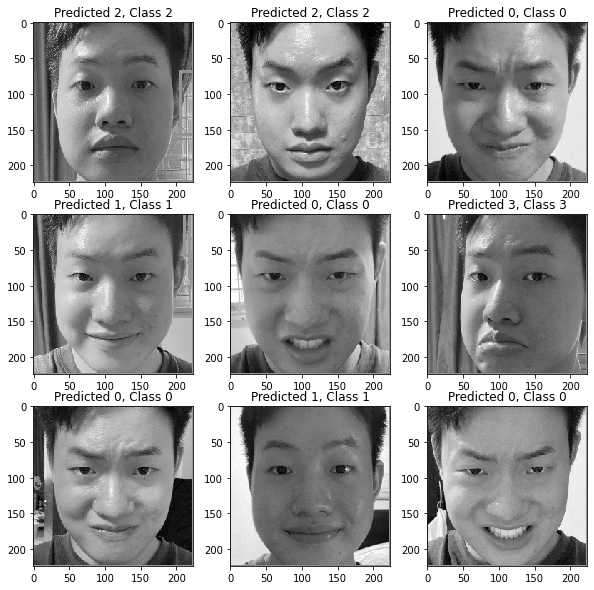

In [ ]:
plt.figure(figsize=(10,10))
for i, correct in enumerate(correct_classified[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(224,224), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(y_classes[correct], y_test[correct]))
    #plt.tight_layout()

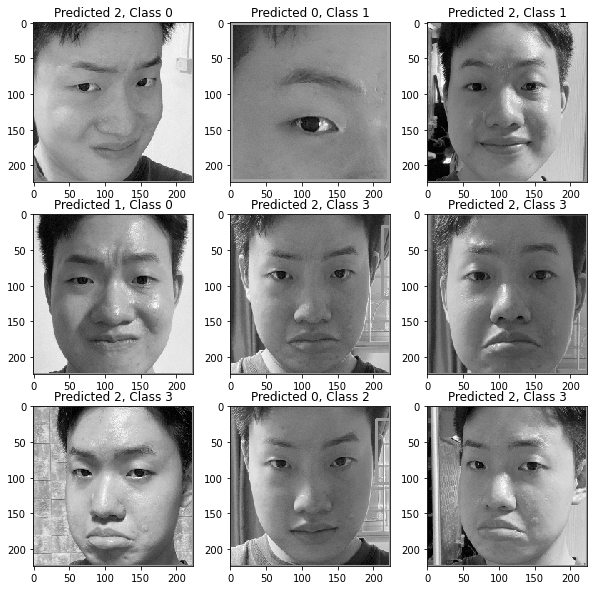

In [ ]:
plt.figure(figsize=(10,10))
for i, incorrect in enumerate(wrong_classified[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(224,224), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(y_classes[incorrect], y_test[incorrect]))
    #plt.tight_layout()

###Activations

In [ ]:
keract_inputs = X_test[1:2]
keract_targets = y_test[:0]
activations = get_activations(cnn3, keract_inputs)
display_activations(activations=activations,cmap='YlGnBu')

Output hidden; open in https://colab.research.google.com to view.